# Calibration of the Chaboche mecanical model with bayesian methods

## Deterministic model

The Chaboche mecanical law predicts the stress depending on the strain:
$$
\sigma = g(\epsilon,R,C,\gamma) = R + \frac{C}{\gamma} (1-\exp(-\gamma\epsilon))
$$

where:

- $\epsilon$ is the strain,
- $\sigma$ is the stress (Pa),
- $R$, $C$, $\gamma$ are the parameters.

Caution: 
* The strain $\epsilon$ is not the random error of the least squares model. 
* The stress $\sigma$ is not the standard deviation of the random noise of the output observations.

The variables have the following distributions and are supposed to be independent.

| Random var. | Distribution | 
|--|--|
| $R$ | Lognormal ($\mu = 750$ MPa, $\sigma = 11$ MPa) |
| $C$ | Normal ($\mu = 2750$ MPa, $\sigma = 250$ MPa) |
| $\gamma$ | Normal ($\mu = 10$, $\sigma = 2$) |
| $\epsilon$ | Uniform(a=0, b=0.07). |

## Parameters to calibrate

The vector of parameters to calibrate is: 
$$
\theta = (R,C,\gamma).
$$

We set:

- $R = 750\times 10^6$,
- $C = 2750\times 10^6$,
- $\gamma = 10$.

## Observations

In order to create a calibration problem, we make the hypothesis that the strain has the following distribution:
$$
\epsilon \sim Uniform(0,0.07).
$$

Moreover, we consider a gaussian noise on the observed constraint:
$$
\epsilon_\sigma \sim \mathcal{N} \left(0,10\times 10^6\right)
$$

and we make the hypothesis that the observation errors are independent.
We set the number of observations to:
$$
n = 100.
$$

We generate a Monte-Carlo samplg with size $n$:
$$
\sigma_i = g(\epsilon_i,R,C,\gamma) + (\epsilon_\sigma)_i, 
$$

for $i = 1,..., n$.
The observations are the pairs $\{(\epsilon_i,\sigma_i)\}_{i=1,...,n}$, i.e. each observation is a couple made of the strain and the corresponding stress.

## Thanks to

- Antoine Dumas, Phimeca


## References

- J. Lemaitre and J. L. Chaboche (2002) "Mechanics of solid materials" Cambridge University Press.

## Generate the observations

In [1]:
import numpy as np
import openturns as ot

Define the model.

In [2]:
def modelChaboche(X):
    strain, R, C, gamma = X
    stress = R + C * (1.0 - np.exp(-gamma * strain)) / gamma
    return [stress]

Create the Python function.

In [3]:
g = ot.PythonFunction(4, 1, modelChaboche)

Define the random vector.

In [4]:
Strain = ot.Uniform(0.0, 0.07)
unknownR = 750e6
unknownC = 2750e6
unknownGamma = 10.0
R = ot.Dirac(unknownR)
C = ot.Dirac(unknownC)
Gamma = ot.Dirac(unknownGamma)

Strain.setDescription(["Strain"])
R.setDescription(["R"])
C.setDescription(["C"])
Gamma.setDescription(["Gamma"])

Create the joint input distribution function.

In [5]:
inputRandomVector = ot.ComposedDistribution([Strain, R, C, Gamma])

Create the Monte-Carlo sample.

In [6]:
sampleSize = 100
inputSample = inputRandomVector.getSample(sampleSize)
outputStress = g(inputSample)
outputStress[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[y0] data=[[8.48052e+08],[8.76764e+08],[7.74846e+08],[7.56186e+08],[8.09312e+08]]

Plot the histogram of the output.

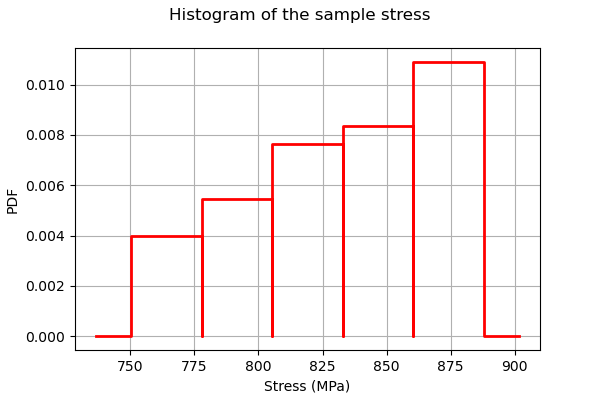

In [7]:
histoGraph = ot.HistogramFactory().build(outputStress / 1.0e6).drawPDF()
histoGraph.setTitle("Histogram of the sample stress")
histoGraph.setXTitle("Stress (MPa)")
histoGraph.setLegends([""])
histoGraph

Generate observation noise.

In [8]:
stressObservationNoiseSigma = 10.0e6  # (Pa)
noiseSigma = ot.Normal(0.0, stressObservationNoiseSigma)
sampleNoiseH = noiseSigma.getSample(sampleSize)
observedStress = outputStress + sampleNoiseH

In [9]:
observedStrain = inputSample[:, 0]

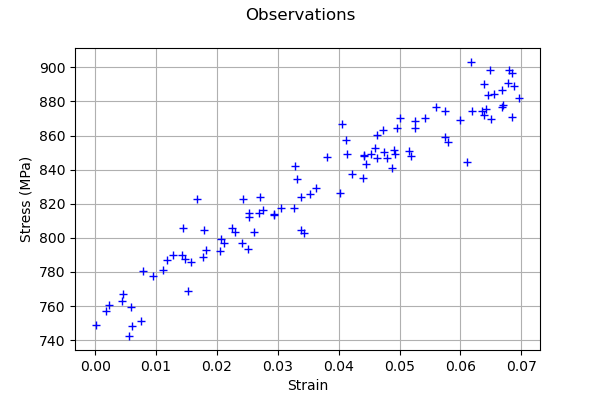

In [10]:
graph = ot.Graph("Observations", "Strain", "Stress (MPa)", True)
cloud = ot.Cloud(observedStrain, observedStress / 1.0e6)
graph.add(cloud)
graph

## Set the calibration parameters

Define the value of the reference values of the $\theta$ parameter. In the bayesian framework, this is called the mean of the *prior* gaussian distribution. In the data assimilation framework, this is called the *background*.

In [11]:
R = 700e6  # Exact : 750e6
C = 2500e6  # Exact : 2750e6
Gamma = 8.0  # Exact : 10
thetaPrior = ot.Point([R, C, Gamma])

The following statement create the calibrated function from the model. The calibrated parameters R, C, Gamma are at indices 1, 2, 3 in the inputs arguments of the model.

In [12]:
calibratedIndices = [1, 2, 3]
mycf = ot.ParametricFunction(g, calibratedIndices, thetaPrior)

## Gaussian calibration parameters

The standard deviation of the observations errors. In general, this value is unknown and must be guessed. In this example we use the same value as the true value.

In [13]:
sigmaStress = 10.0e6  # (Pa) (true value : 10.0e6)

Define the covariance matrix of the output Y of the model. In this particular case, the observation error is assumed to be constant across the observations. Hence, we provide only a single covariance matrix with dimension 1: this matrix will be used for all observations. This is the *local* way to define the covariance matrix of the observation errors.

In [14]:
errorCovariance = ot.CovarianceMatrix(1)
errorCovariance[0, 0] = sigmaStress ** 2

Define the covariance matrix of the parameters $\theta$ to calibrate. We use here a diagonal covariance matrix (but a more general matrix could be used as well if this matches the prior information).

In [15]:
sigmaR = 0.1 * R
sigmaC = 0.1 * C
sigmaGamma = 0.1 * Gamma

In [16]:
sigma = ot.CovarianceMatrix(3)
sigma[0, 0] = sigmaR ** 2
sigma[1, 1] = sigmaC ** 2
sigma[2, 2] = sigmaGamma ** 2
sigma

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[4.9e+15,0,0,0,6.25e+16,0,0,0,0.64]

## Gaussian linear calibration

The `GaussianLinearCalibration` class performs the gaussian linear calibration by linearizing the model in the neighbourhood of the prior.

In [17]:
algo = ot.GaussianLinearCalibration(
    mycf, observedStrain, observedStress, thetaPrior, sigma, errorCovariance
)

The `run` method computes the solution of the problem.

In [18]:
algo.run()

In [19]:
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [20]:
thetaMAP = calibrationResult.getParameterMAP()
thetaMAP

class=Point name=Unnamed dimension=3 values=[7.49845e+08,2.60366e+09,8.15841]

We can compute a 95% confidence interval of the parameter $\theta^\star$. 

In [21]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[7.44583e+08,2.40769e+09,6.45772] upper bound=class=Point name=Unnamed dimension=3 values=[7.55108e+08,2.79962e+09,9.8591] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

We can see that all three parameters are estimated with a large confidence interval.

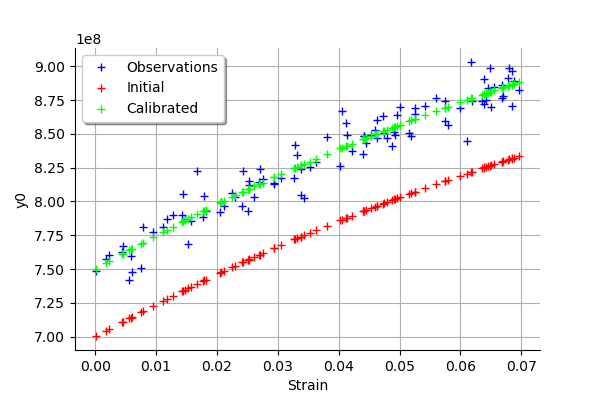

In [22]:
graph = calibrationResult.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
graph

We see that there is a good fit after calibration, since the predictions after calibration (i.e. the green crosses) are close to the observations (i.e. the blue crosses).

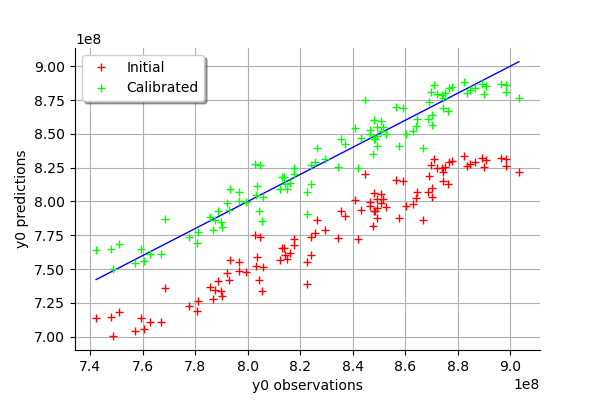

In [23]:
calibrationResult.drawObservationsVsPredictions()

We see that there is a much better fit after calibration, since the predictions are close to the diagonal of the graphics.

The observation error is predicted by linearizing the problem at the prior. 

In [24]:
observationError = calibrationResult.getObservationsError()
observationError

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1e+07] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

This can be compared to the residuals distribution, which is computed at the posterior.

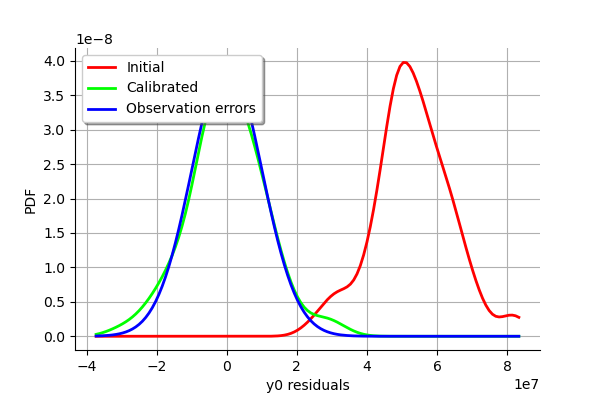

In [25]:
graph = calibrationResult.drawResiduals()
graph.setLegendPosition("topleft")
graph

The analysis of the distribution of the residuals (the blue line) shows that the distribution is centered on zero and symmetric. This indicates that the calibration performed well. Moreover, the distribution of the residuals is close to being gaussian.

The observation error distribution (in green) is close to the actual residuals distribution. This implies that the Gaussian hypothesis of the residuals is validated. Therefore, the confidence intervals of $\theta^\star$ can be trusted. 

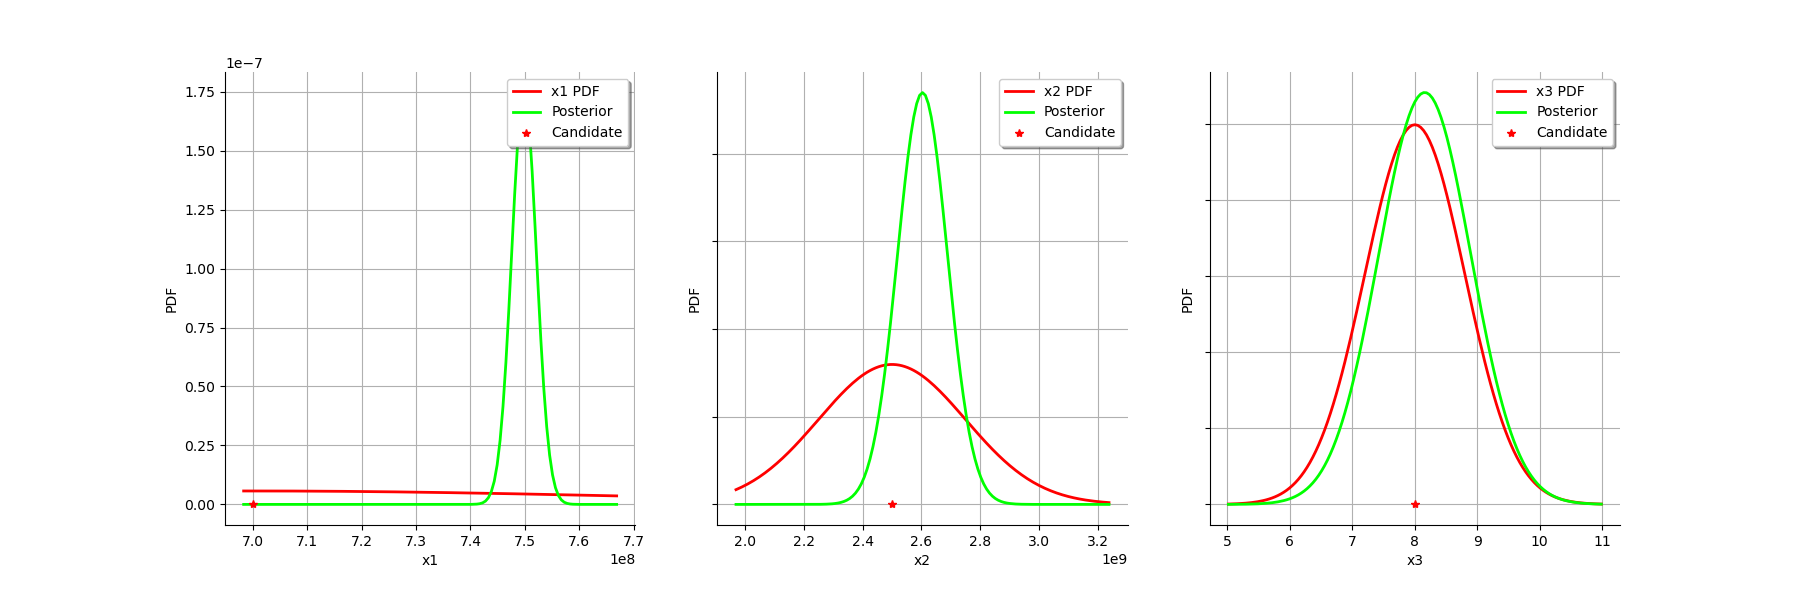

In [26]:
calibrationResult.drawParameterDistributions()

We see that the prior and posterior distribution are close to each other for the $C$ variable: the observations did not convey much information for this variable.

## Gaussian nonlinear calibration

The `GaussianNonLinearCalibration` class performs the gaussian nonlinear calibration.

In [27]:
algo = ot.GaussianNonLinearCalibration(
    mycf, observedStrain, observedStress, thetaPrior, sigma, errorCovariance
)

The `run` method computes the solution of the problem.

In [28]:
algo.run()

In [29]:
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [30]:
thetaMAP = calibrationResult.getParameterMAP()
thetaMAP

class=Point name=Unnamed dimension=3 values=[7.50235e+08,2.58913e+09,8.07577]

We can compute a 95% confidence interval of the parameter $\theta^\star$. 

In [31]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[7.43986e+08,2.41193e+09,7.60223] upper bound=class=Point name=Unnamed dimension=3 values=[7.56916e+08,2.76289e+09,8.61261] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

We can see that all three parameters are estimated with a large confidence interval.

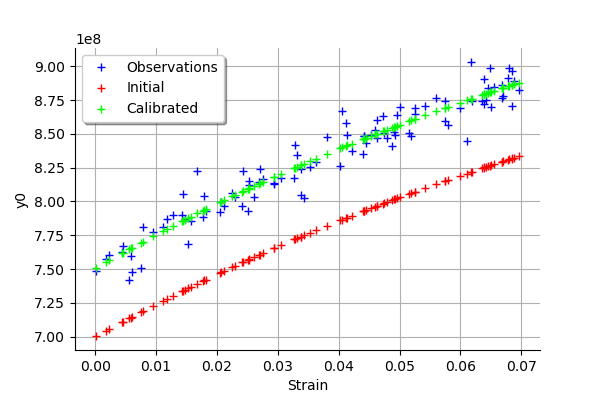

In [32]:
graph = calibrationResult.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
graph

We see that there is a good fit after calibration, since the predictions after calibration (i.e. the green crosses) are close to the observations (i.e. the blue crosses).

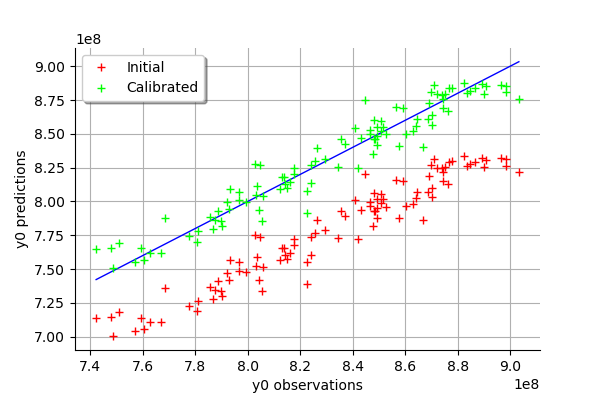

In [33]:
calibrationResult.drawObservationsVsPredictions()

We see that there is a much better fit after calibration, since the predictions are close to the diagonal of the graphics.

The observation error is predicted by bootstraping the problem at the posterior. 

In [34]:
observationError = calibrationResult.getObservationsError()
observationError

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[-28462.7] sigma=class=Point name=Unnamed dimension=1 values=[1e+07] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

This can be compared to the residuals distribution, which is computed at the posterior.

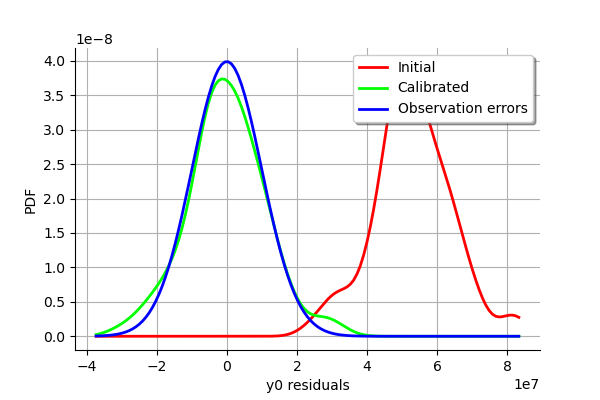

In [35]:
calibrationResult.drawResiduals()

The analysis of the distribution of the residuals (the blue line) shows that the distribution is approximately centered on zero and symmetric. This indicates that the calibration performed well. Moreover, the distribution of the residuals is close to being gaussian.

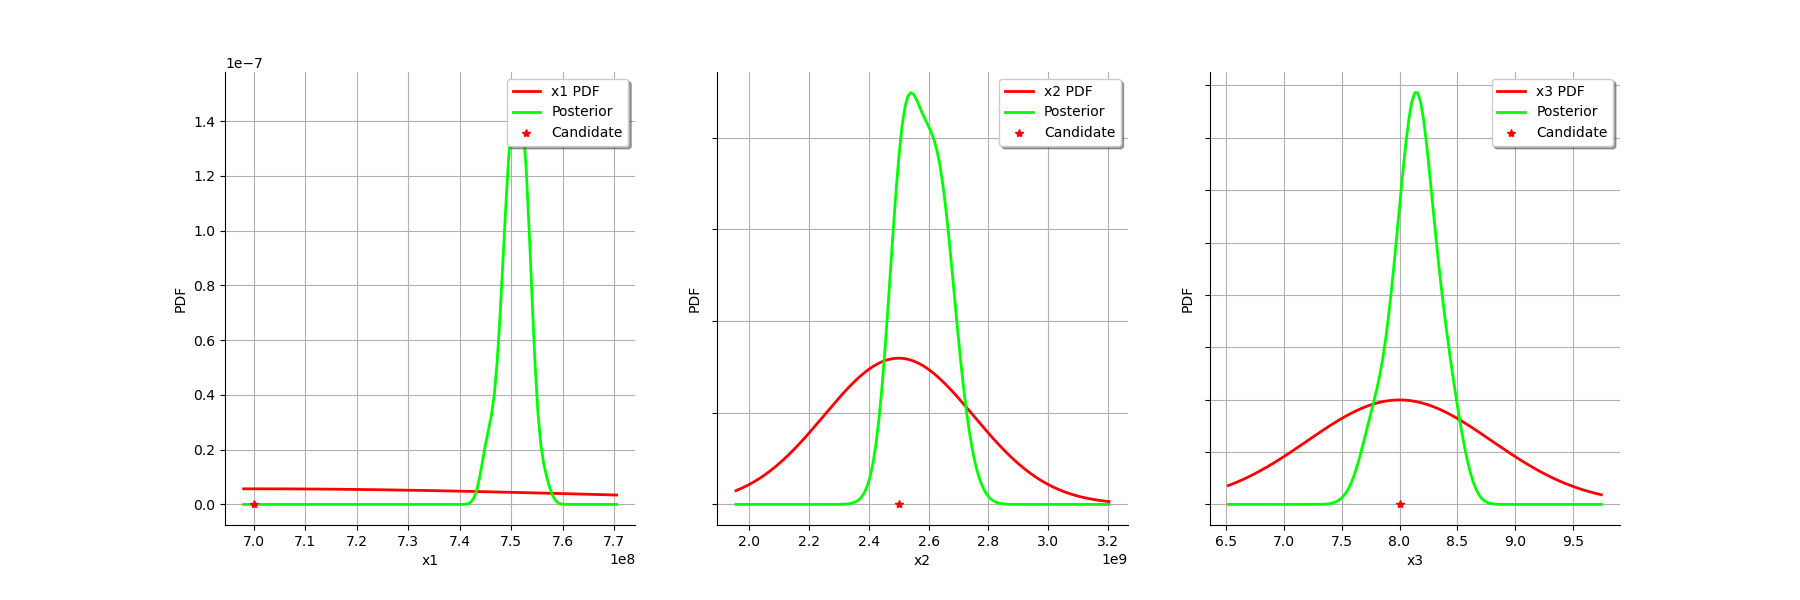

In [36]:
calibrationResult.drawParameterDistributions()

The posterior distribution of R is very spiky compared to the relatively flat prior. This implies that the observations have brought a very significant information on the parameter R.

We see that the prior and posterior distribution are close to each other for C and Gamma, but not superimposed: the observations significantly brought information during the calibration. 

When we compare the three plots, it seems that the most significant parameter is R, because the distance between the posterior and prior distributions is larger for this parameter. 

## Exercice 1 : changement du paramètre de référence

* Changer le paramètre `thetaPrior` et utiliser les valeurs numériques suivantes :

In [37]:
R = 650e6  # Exact : 750e6
C = 2300e6  # Exact : 2750e6
Gamma = 6.0  # Exact : 10
thetaPrior = ot.Point([R, C, Gamma])

* Comment évolue la valeur du paramètre optimal dans le cas du calage gaussien linéaire ? Pouvez-vous expliquer les causes de ces différences ?
* Comment évolue la valeur du paramètre optimal dans le cas du calage gaussien non-linéaire ? Pouvez-vous expliquer les causes de ces différences ?

## Exercice 2 : changement de la matrice de covariance à priori

Dans cette question, on considère la méthode de calage gaussien linéaire.

* Changer le paramètre `sigma` et utiliser les valeurs numériques suivantes :

In [38]:
coefficientOfVariation = 0.5
sigmaR = coefficientOfVariation * R
sigmaC = coefficientOfVariation * C
sigmaGamma = coefficientOfVariation * Gamma

In [39]:
sigma = ot.CovarianceMatrix(3)
sigma[0, 0] = sigmaR ** 2
sigma[1, 1] = sigmaC ** 2
sigma[2, 2] = sigmaGamma ** 2
sigma

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1.05625e+17,0,0,0,1.3225e+18,0,0,0,9]

* Dessiner la loi à posteriori. 
* Quels sont les changements dans les lois ? Pouvez-vous expliquer ces changements ?
* Changer le paramètre `sigma` et utiliser les valeurs numériques suivantes :

In [40]:
coefficientOfVariation = 0.01
sigmaR = coefficientOfVariation * R
sigmaC = coefficientOfVariation * C
sigmaGamma = coefficientOfVariation * Gamma

In [41]:
sigma = ot.CovarianceMatrix(3)
sigma[0, 0] = sigmaR ** 2
sigma[1, 1] = sigmaC ** 2
sigma[2, 2] = sigmaGamma ** 2
sigma

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[4.225e+13,0,0,0,5.29e+14,0,0,0,0.0036]

* Dessiner la loi à posteriori. 
* Quels sont les changements dans les lois ? Pouvez-vous expliquer ces changements ?
* Faire de même avec le calage gaussien non-linéaire.

## Exercice 3 : changement de la covariance du bruit d'observation

* Définir les valeurs suivantes du bruit d'observation.

In [42]:
sigmaStress = 1.0e7  # (Pa) Valeur de référence

In [43]:
sigmaStress = 10.0e7  # (Pa) Nouvelle valeur 1

In [44]:
sigmaStress = 100.0e7  # (Pa) Nouvelle valeur 2

* Pour le calage gaussien linéaire, dessiner les lois à priori et à posteriori. 
* Quels sont les changements ? Pouvez-vous expliquer ces changements ?